## Creating a logistic regression model in Python!

In [53]:
# Reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Logistic%20Regression%20balanced.ipynb

### Import necessary libraries:

In [54]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

plt.rc("font", size=14) 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#from mpl_toolkits.basemap import Basemap


import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

#Read data from a local csv file:

##Will change this to scrape files from the Smartfin.org website later.
#data = pd.read_csv('Motion_13735.CSV', header=0)   
#data = data.dropna()

#Print out the column headings:
#print(data.shape)
#print(list(data.columns))

### Summary of specific ride IDs:

In [55]:
#Make sure the ride_id and the footage file match up:
ride_ids = ['15692']
footage_file = 'Footage3.txt'


#ride_ids = ['14827']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)
# 14888 - First Buoy Calibration Experiment (July 30)
# 15218 - Jasmine's Second Ride Sesh filmed with GoPro (Aug 29) //no footage
# 15629 - Jasmine's First Ride Sesh filmed with VIRB (Oct. 24) //first labelled footage!
# 15669 - Jasmine's Second Ride Sesh filmed with VIRB (Nov. 7) //second labelled footage!
# 15692 - Jasmine's 3rd Ride Sesh filmed with VIRB (Nov. 9) //third labelled footage!
# 15686 - Jasmine's 4th Ride Sesh filmed with VIRB (Nov. 11) //fourth labelled footage!

## Fin ID Scraper (pulls dataframes for specific ride id from website):

In [56]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            #print(ocean_df_small)
            #print(motion_df_small)
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
    
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])


##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.

#We can also check to see if the surfboard was recording "in-water-freq" or 
#"out-of-water-freq" based on how many NaN values we see. 
print(motion_df)

https://surf.smartfin.org/ride/15692
https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181109191556_Ocean.CSV
Ride data has been uploaded.
                                         Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:03.822           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.855           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.888           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.921           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.954           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.987           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:04.020           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 1

## Drop the NA values from the dataframe:

In [57]:
#Drop the latitude and longitude values since most of them are Nan:
motion_df_dropped = motion_df.drop(columns=['Latitude', 'Longitude'])


#Drop the NAN values from the motion data:
motion_df_dropped = motion_df_dropped.dropna(axis=0, how='any')
print(motion_df_dropped)

                                         Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   
        2018-11-09 19:16:06.

## Create an elapsed time field to sync Smartfin data with Video Footage:

In [58]:
#Create an elapsed_timedelta field:

#timedelta_values = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
#motion_df_dropped.insert(loc=1, column='TimeDelta', value=timedelta_values, drop=True)
motion_df_dropped['TimeDelta'] = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
#print(elapsed_timedelta)
#motion_df_dropped.head()
motion_df_dropped.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  
ride_id UTC                                 
15692   2018-11-09 19:16:03.789        0.0  
        2018-11-09 19:16:04.053      252.5  
        2018-11-09 19:16:04.284      501.5  
        2018-11-09 19:16:04.548      753.5  
        2018-11-09 19:16:04.812     1003.5  
        2018-11-09 19:16:05.043     1253.5  
        2018-11-09 19:16:05.307     1504.5  
        2018-11-09 19:16:05.571     1755.5  
        2018-11-09 19:16:05.802     2006.5  
        2018-11-09 19:16:06.066     2258.5

## Footage sync code written by Alina:

In [59]:
#Footage sync code written by Alina: (Miulti-Column)

import time

#simple method: only walking, paddling, floating, surfing
#complex method: columns created based on footage file labels
def label_data( footage_file = 'Footage.txt', labelling_method = 'simple', sync_threshold = 20000 ):
    
    #First, perform sync
    sync_buf = 0
    with open(footage_file) as file:
        for line in file:
            labelled_time = line.split(None, 2) 
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip()
            if labelled_time[1].lower() == 'sync': #Assumption that first word in sync line is "sync"
                sync_time = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000
                index = 0
                start = 0
                end = 0
                #Syncing occurs when IMU A2 data is negative for a longer period than the provided threshold
                #Default is 20 seconds
                for data in motion_df_dropped['IMU A2']:
                    if data < 0 and start == 0:
                        start = motion_df_dropped['TimeDelta'][index]
                    elif data > 0 and start != 0:
                        end = motion_df_dropped['TimeDelta'][index]
                        if end - start > sync_threshold:
                            sync_buf = start - sync_time
                            break
                        start = 0
                    index += 1

    accepted_labels = set()
    if labelling_method == 'simple':
        accepted_labels = {'WALKING', 'PADDLING', 'FLOATING', 'SURFING'}

        #Create new DataFrame containing label info
        label_frame = pd.DataFrame(0, index = motion_df_dropped.index, columns = accepted_labels)
        for label in accepted_labels:
            label_frame[label] = [0] * len(motion_df_dropped['Time'])
    
    #Convention of labelled footage text: "MINUTE:SECOND LABEL"
    elapsed_time = 0
    cur_label = ''
    buffer = 0
    with open(footage_file) as file:
        for line in file:
            
            if labelling_method == 'simple':
                labelled_time = line.split(None, 2) #simple categorizes on a one-word basis
            else:
                labelled_time = line.split(None, 1) #complex requires the entire label
                
            #If the first word is not a properly formatted time, the line cannot be read
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
                cur_timeMS = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000 + sync_buf
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip() #Remove potential newline
                
            #Check for end of video and modify buffer accordingly
            if labelled_time[1].lower() == 'end of video': #Assumption that label end video with "end of video"
                buffer += cur_timeMS
                
            #----Complex "mode" below: --------
                
            #Modify accepted labels list if reading a new label and in complex mode
            elif labelling_method == 'complex' and (labelled_time[1].upper() not in accepted_labels):
                accepted_labels.add(labelled_time[1].upper())
                if not cur_label:
                    label_frame = pd.DataFrame(0, index = motion_df_dropped.index, columns = accepted_labels)
                label_frame[labelled_time[1].upper()] = [0] * len(motion_df_dropped['Time'])
                
            if labelled_time[1].upper() in accepted_labels:
                while (elapsed_time < len(motion_df_dropped['Time']) and
                      (np.isnan(motion_df_dropped['TimeDelta'][elapsed_time]) or
                       motion_df_dropped['TimeDelta'][elapsed_time] < cur_timeMS + buffer)):
                    if cur_label != '':
                        label_frame[cur_label][elapsed_time] = 1
                    elapsed_time += 1
                if labelled_time[1].upper() != 'end of video':
                    cur_label = labelled_time[1].upper()

    labelled = pd.concat([motion_df_dropped, label_frame], axis = 1)

    return labelled

pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000

In [60]:
motion_df_simple = label_data(footage_file)
motion_df_simple.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  FLOATING  WALKING  PADDLING  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789        0.0         0        0         0   
        2018-11-09 19:16:04.053      252.5         0        0         0   
        2018-11-09 19:16:04.284      501.5         0        0         0   
        2018-11-09 19:16:04.548      753.5         0        0         0   
        2018-11-09 19:16:04.812     1003.5         0        0         0   
        2018-11-09 19:16:05.043     1253.5         0        0         0   
        2018-11-09 19:16:05.307     1504.5         0        0         0   
        2018-11-09 19:16:05.571     1755.5         0        0         0   
        2018-11-09 19:16:05.802     2006.5         0        0         0   
        2018-11-09 19:16:06.066     2258.5         0        0         0   

                                 SURFING  
ride_id UTC                               
15692   2018-11-09 19:16:03.789        0  
        2018-11-09 19:16:04.053        0  
        2018-11-09 19:16:04.284        0  
        2018-11-09 19:16:04.548        0  
        2018-11-09 19:16:04.812        0  
        2018-11-09 19:16:05.043        0  
        2018-11-09 19:16:05.307        0  
        2018-11-09 19:16:05.571        0  
        2018-11-09 19:16:05.802        0  
        2018-11-09 19:16:06.066        0

In [61]:
motion_df_complex = label_data('Footage3.txt', 'complex')
motion_df_complex.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  SYNC  FLIP BOARD RIGHT SIDE UP  \
ride_id UTC                                                                  
15692   2018-11-09 19:16:03.789        0.0     0                         0   
        2018-11-09 19:16:04.053      252.5     0                         0   
        2018-11-09 19:16:04.284      501.5     0                         0   
        2018-11-09 19:16:04.548      753.5     0                         0   
        2018-11-09 19:16:04.812     1003.5     0                         0   
        2018-11-09 19:16:05.043     1253.5     0                         0   
        2018-11-09 19:16:05.307     1504.5     0                         0   
        2018-11-09 19:16:05.571     1755.5     0                         0   
        2018-11-09 19:16:05.802     2006.5     0                         0   
        2018-11-09 19:16:06.066     2258.5     0                         0   

                                 WALKING IN WATER  PUSH-OFF  \
ride_id UTC                                                   
15692   2018-11-09 19:16:03.789                 0         0   
        2018-11-09 19:16:04.053                 0         0   
        2018-11-09 19:16:04.284                 0         0   
        2018-11-09 19:16:04.548                 0         0   
        2018-11-09 19:16:04.812                 0         0   
        2018-11-09 19:16:05.043                 0         0   
        2018-11-09 19:16:05.307                 0         0   
        2018-11-09 19:16:05.571                 0         0   
        2018-11-09 19:16:05.802                 0         0   
        2018-11-09 19:16:06.066                 0         0   

                                 PADDLING INTO WAVES  SIT-UP  FLOATING  \
ride_id UTC                                                              
15692   2018-11-09 19:16:03.789                    0       0         0   
        2018-11-09 19:16:04.053                    0       0         0   
        2018-11-09 19:16:04.284                    0       0         0   
        2018-11-09 19:16:04.548                    0       0         0   
        2018-11-09 19:16:04.8

## Concatenate multiple footage files that we have so far to create a larger mass of data samples. 

In [62]:
df1_complex = label_data('Footage.txt', 'complex')
df2_complex = label_data('Footage2.txt', 'complex')
df3_complex = label_data('Footage3.txt', 'complex')
df4_complex = label_data('Footage4.txt', 'complex')

df_concatenated = pd.concat([df1_complex, df2_complex, df3_complex, df4_complex])

print("Shape of first dataframe:", df1_complex.shape)
print("Shape of all combined dataframes:", df_concatenated.shape)

print("Printing dataframe...")
#print(df1_complex.head(10))
print(df_concatenated.head(10))

Shape of first dataframe: (21645, 32)
Shape of all combined dataframes: (86580, 40)
Printing dataframe...
                                 DISCARD  DONE  DONE, OUT OF WATER  \
ride_id UTC                                                          
15692   2018-11-09 19:16:03.789      0.0   NaN                 NaN   
        2018-11-09 19:16:04.053      0.0   NaN                 NaN   
        2018-11-09 19:16:04.284      0.0   NaN                 NaN   
        2018-11-09 19:16:04.548      0.0   NaN                 NaN   
        2018-11-09 19:16:04.812      0.0   NaN                 NaN   
        2018-11-09 19:16:05.043      0.0   NaN                 NaN   
        2018-11-09 19:16:05.307      0.0   NaN                 NaN   
        2018-11-09 19:16:05.571      0.0   NaN                 NaN   
        2018-11-09 19:16:05.802      0.0   NaN                 NaN   
        2018-11-09 19:16:06.066      0.0   NaN                 NaN   

                                 END SURF SESH  FLIP 

/Users/jasminesimmons/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


### Convert the Raw IMU data values to real units:

In [63]:
#correct IMU data

#make a deep copy of motion_df_labelled
df_converted = motion_df_complex.copy(deep = 'true')

#for rows in df_corrected
for row in range(0, df_converted.shape[0]):
    
    #convert acceleromters (new: m/s^2)
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A1')] *= -0.019141  #forwards/backwards
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A2')] *= 0.019141   #upside down/right side up
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A3')] *= 0.019141   #sideways: negative = left, positive = right
 
    #convert gyroscopes (new: deg/s)
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G1')] /= 8.2        #roll
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G2')] /= 8.2        #yaw
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G3')] /= 8.2        #pitch (flipping forwards/backwards)

motion_df_complex.head(10)    


Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  SYNC  FLIP BOARD RIGHT SIDE UP  \
ride_id UTC                                                                  
15692   2018-11-09 19:16:03.789        0.0     0                         0   
        2018-11-09 19:16:04.053      252.5     0                         0   
        2018-11-09 19:16:04.284      501.5     0                         0   
        2018-11-09 19:16:04.548      753.5     0                         0   
        2018-11-09 19:16:04.812     1003.5     0                         0   
        2018-11-09 19:16:05.043     1253.5     0                         0   
        2018-11-09 19:16:05.307     1504.5     0                         0   
        2018-11-09 19:16:05.571     1755.5     0                         0   
        2018-11-09 19:16:05.802     2006.5     0                         0   
        2018-11-09 19:16:06.066     2258.5     0                         0   

                                 WALKING IN WATER  PUSH-OFF  \
ride_id UTC                                                   
15692   2018-11-09 19:16:03.789                 0         0   
        2018-11-09 19:16:04.053                 0         0   
        2018-11-09 19:16:04.284                 0         0   
        2018-11-09 19:16:04.548                 0         0   
        2018-11-09 19:16:04.812                 0         0   
        2018-11-09 19:16:05.043                 0         0   
        2018-11-09 19:16:05.307                 0         0   
        2018-11-09 19:16:05.571                 0         0   
        2018-11-09 19:16:05.802                 0         0   
        2018-11-09 19:16:06.066                 0         0   

                                 PADDLING INTO WAVES  SIT-UP  FLOATING  \
ride_id UTC                                                              
15692   2018-11-09 19:16:03.789                    0       0         0   
        2018-11-09 19:16:04.053                    0       0         0   
        2018-11-09 19:16:04.284                    0       0         0   
        2018-11-09 19:16:04.548                    0       0         0   
        2018-11-09 19:16:04.8

In [64]:
#df_converted.head(10)

In [65]:
#list(df_converted)

In [66]:
## Drop data columns that we don't care about predicting/visualizing: 
df_converted = df_converted.drop(columns=["FLIP BOARD RIGHT SIDE UP", "NEW", "DONE, OUT OF WATER"])
#df_converted = df_converted.drop(columns!=["SURFING, FLOATING, PADDLING INTO WAVES, PADDLING FOR A WAVE, PADDLING FOR POSITION, PADDLING"])

## Plot IMU Signals with Labels:

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 10]

#define a function that plots a column of dataf in relation to time. color coded to match labels in dataf
#requires that:
#dataf has a 'TimeDelta' column
#labels: walking, surfing, floating, paddling

def createPlot (dataf, column):
    
        #create new data frame to be plotted
        #Only consider columns after Velocity
        dfPlot = pd.DataFrame(columns = ['TIME'] + list(dataf)[list(dataf).index('TimeDelta') + 1:], dtype = float)
        
        #add timedelta column from dataf to dfPlot
        dfPlot['TIME'] = dataf['TimeDelta']
        
        #get the index of the column to be graphed
        columnInd = dataf.columns.get_loc(column)
        
        #for each row in dfPlot (number of IMU readings)
        for row in range(0, dfPlot.shape[0]):
            
            #for the indexes of the label columns in dfPlot
            for col in range(1, dfPlot.shape[1]):
                
                #if a label in the row is 1 in dataf
                if dataf.iloc[row, dataf.columns.get_loc(dfPlot.columns[col])] == 1:
                    
                    #add the sensors value to the corresponding column in dfPlot
                    dfPlot.iloc[row, dfPlot.columns.get_loc(dfPlot.columns[col])] = dataf.iloc[row, columnInd]
                    #dfPlot.iloc[row, dfPlot.columns.get]
        
        #Set up colormap so that we don't see a repeat in color when graphing
        #plt.gca().set_prop_cycle('color',plt.cm.plasma(np.linspace(0,1,dfPlot.shape[1])))
        plt.gca().set_prop_cycle('color',plt.cm.tab20(np.linspace(0,1,dfPlot.shape[1])))
        for col in range (1, dfPlot.shape[1]):
            plt.plot(dfPlot['TIME'], dfPlot[list(dfPlot)[col]])
        
        plt.gca().legend(loc = 'lower left')
        plt.title(column)
        plt.xlabel("Time")
        plt.ylabel("IMU Data")

        #file_name = column
        #pdf_string = '.jpg'
        #file_name += pdf_string
        
        #plt.savefig(file_name)
        plt.show()
        
        return 

Creating Plots...


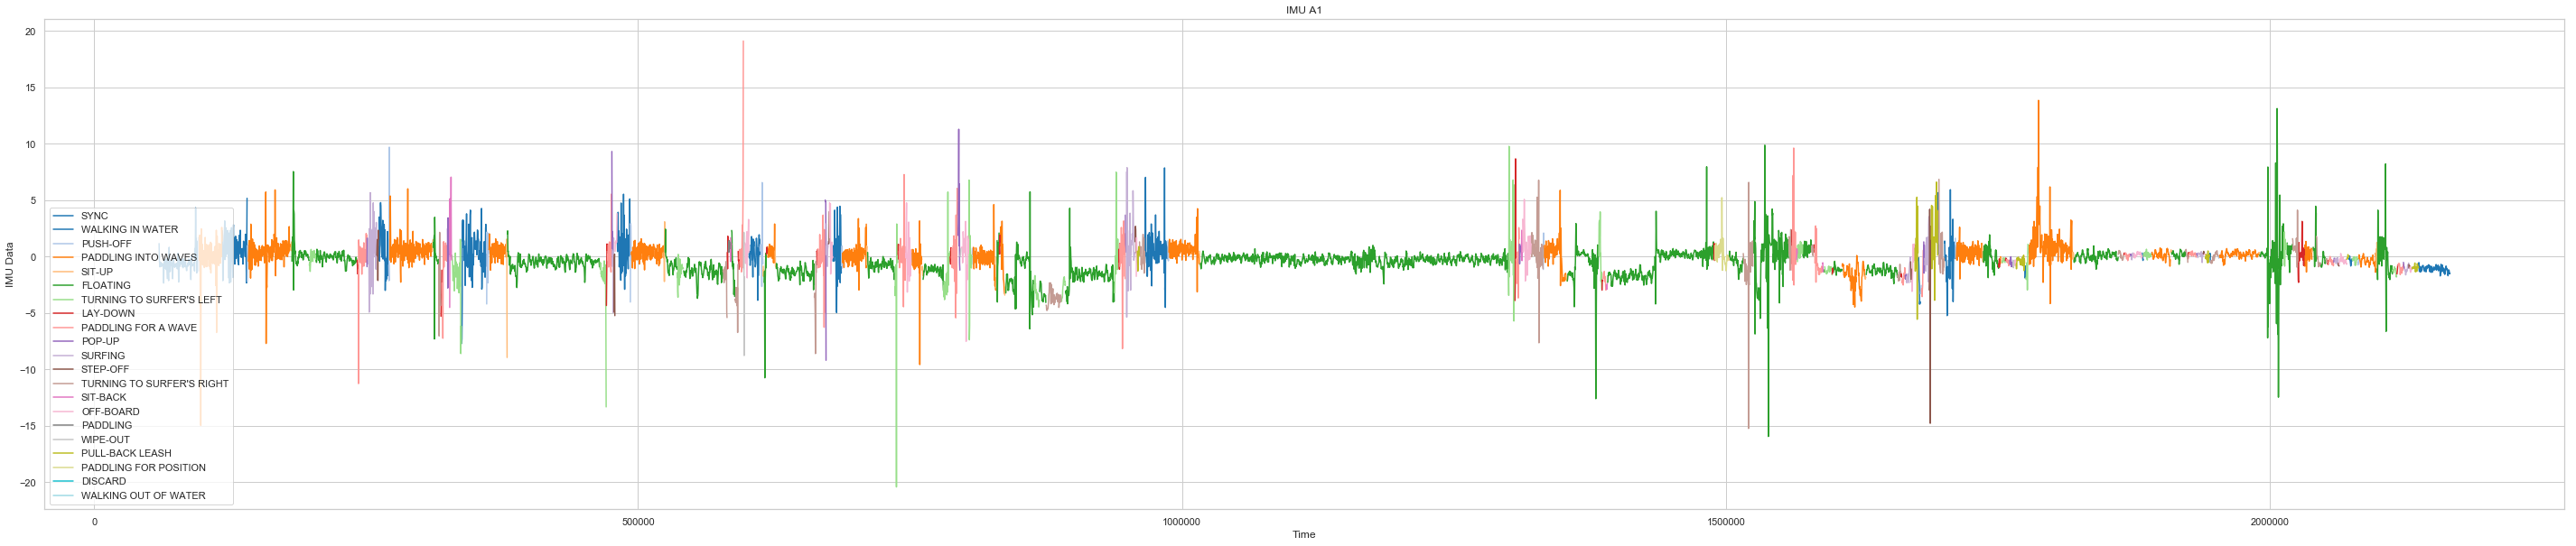

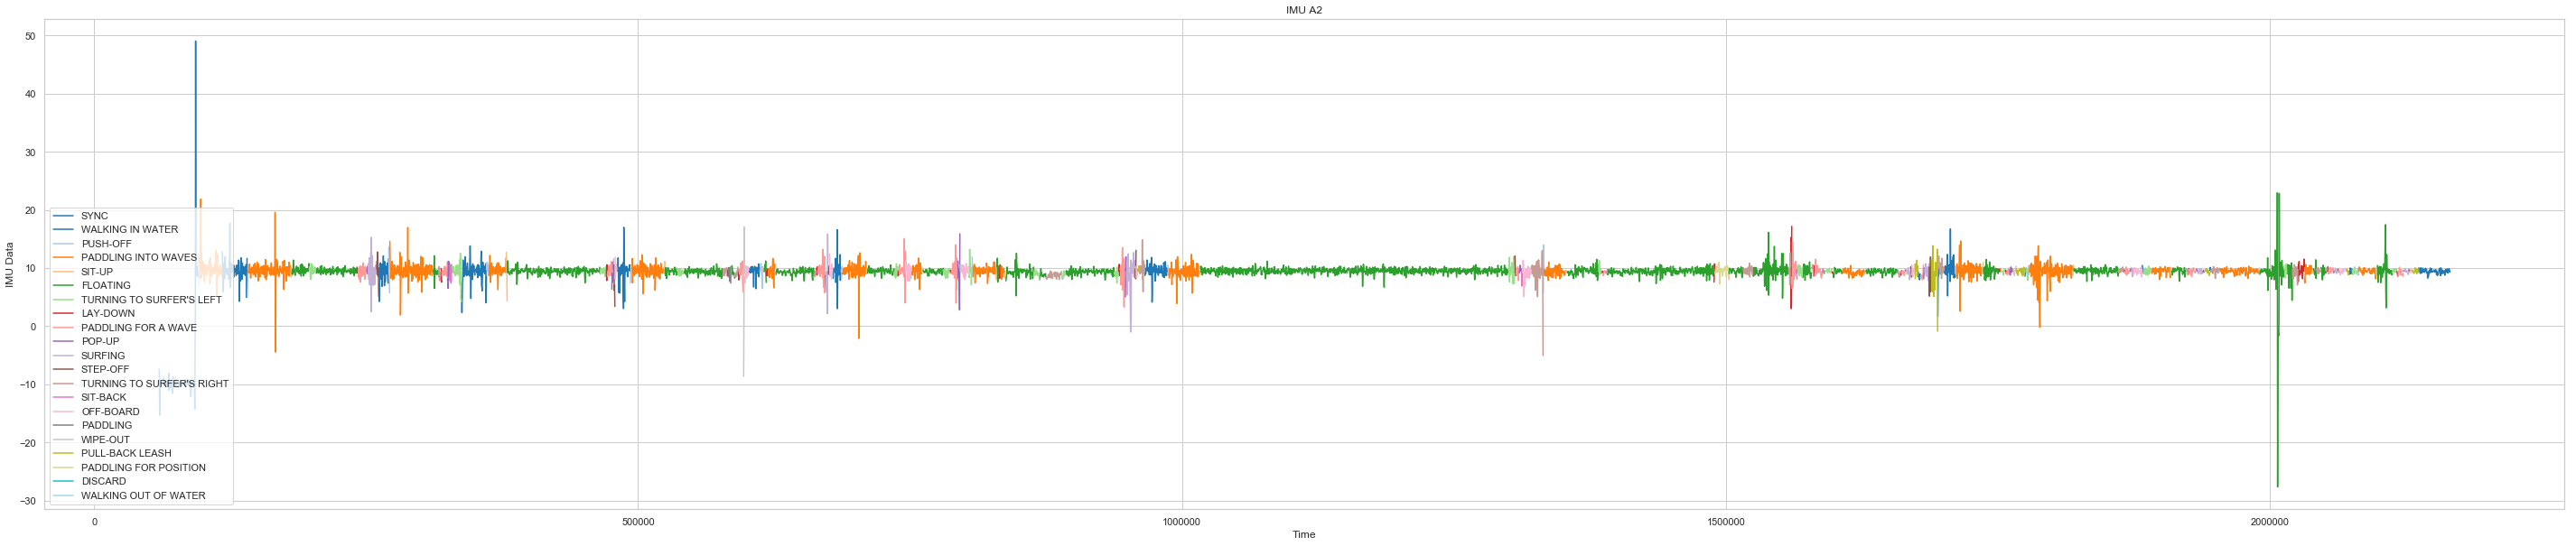

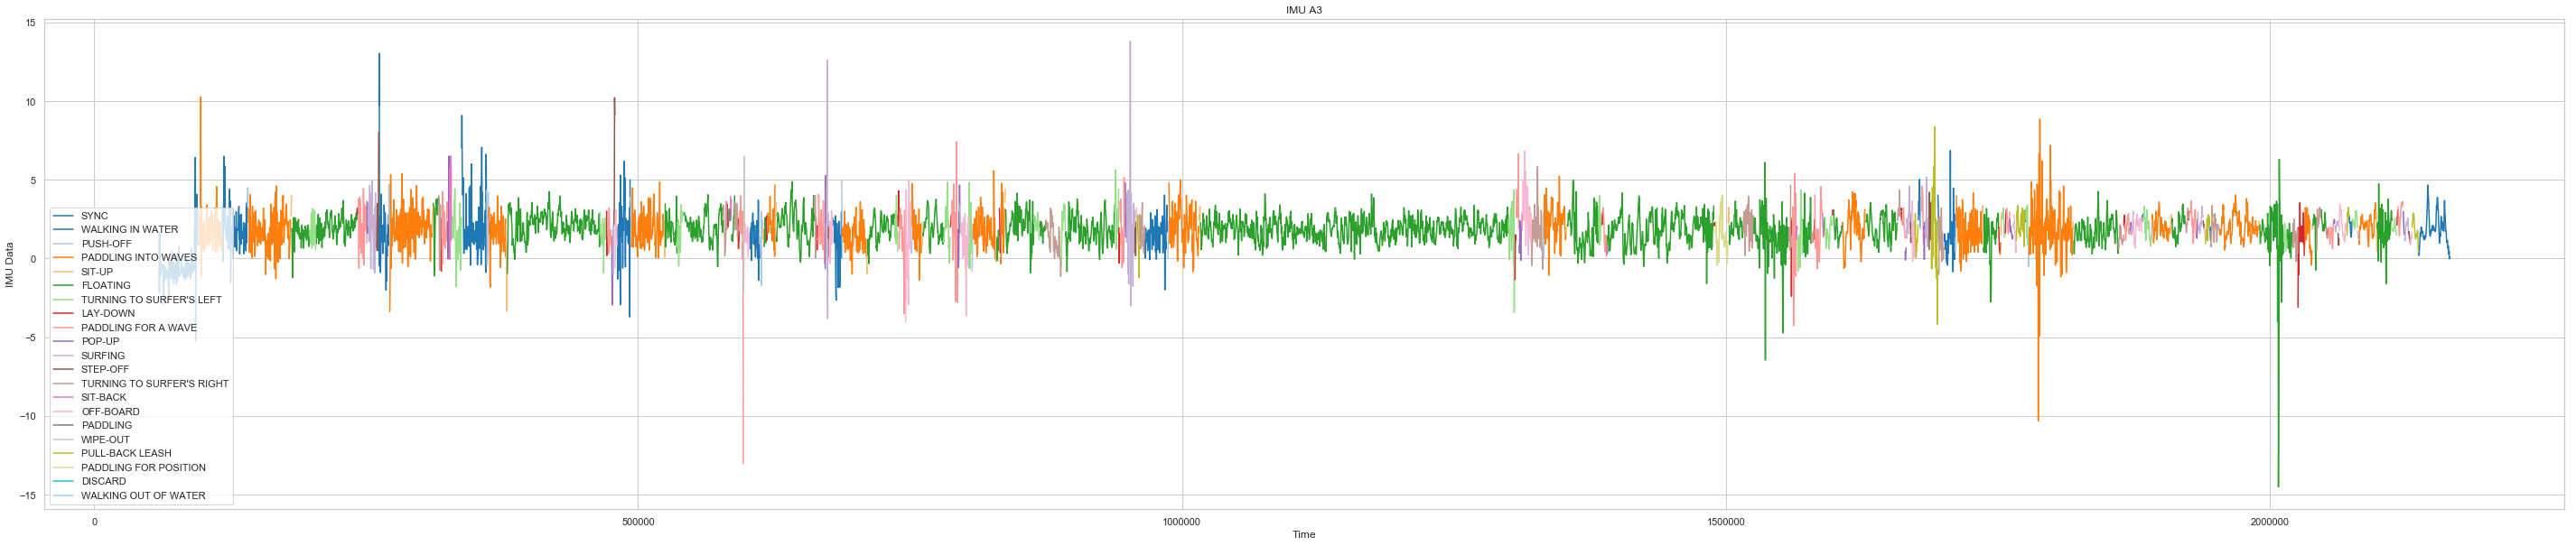

Done


In [68]:
#For plotting, just comment out the "concatenation" lines. 

#Need to clear kernel and then only run all above so that it plots on axes directly below, rather than on another plot
print("Creating Plots...")
createPlot(df_converted,'IMU A1')
createPlot(df_converted,'IMU A2')
createPlot(df_converted,'IMU A3')
#createPlot(df_converted,'IMU G1')
#createPlot(df_converted,'IMU G2')
#createPlot(df_converted,'IMU G3')
#createPlot(df_converted,'IMU M1')
#createPlot(df_converted,'IMU M2')
#createPlot(df_converted,'IMU M3')

print("Done")


### Instead of looking at all labels, just look at floating vs. not floating: 

In [69]:
print(list(df_converted.columns))

drop_list = ['SYNC', 'WALKING IN WATER', 'PUSH-OFF', 'PADDLING INTO WAVES', 'SIT-UP', "TURNING TO SURFER'S LEFT", 'LAY-DOWN', 'PADDLING FOR A WAVE', 'POP-UP', 'SURFING', 'STEP-OFF', "TURNING TO SURFER'S RIGHT", 'SIT-BACK', 'OFF-BOARD', 'PADDLING', 'WIPE-OUT', 'PULL-BACK LEASH', 'PADDLING FOR POSITION', 'DISCARD', 'WALKING OUT OF WATER']
for x in drop_list: 
    if x in df_converted.columns:
        df_converted = df_converted.drop(columns=[x])
                                          
                                          
                                          
                                          

['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', 'TimeDelta', 'SYNC', 'WALKING IN WATER', 'PUSH-OFF', 'PADDLING INTO WAVES', 'SIT-UP', 'FLOATING', "TURNING TO SURFER'S LEFT", 'LAY-DOWN', 'PADDLING FOR A WAVE', 'POP-UP', 'SURFING', 'STEP-OFF', "TURNING TO SURFER'S RIGHT", 'SIT-BACK', 'OFF-BOARD', 'PADDLING', 'WIPE-OUT', 'PULL-BACK LEASH', 'PADDLING FOR POSITION', 'DISCARD', 'WALKING OUT OF WATER']


Creating Plots...


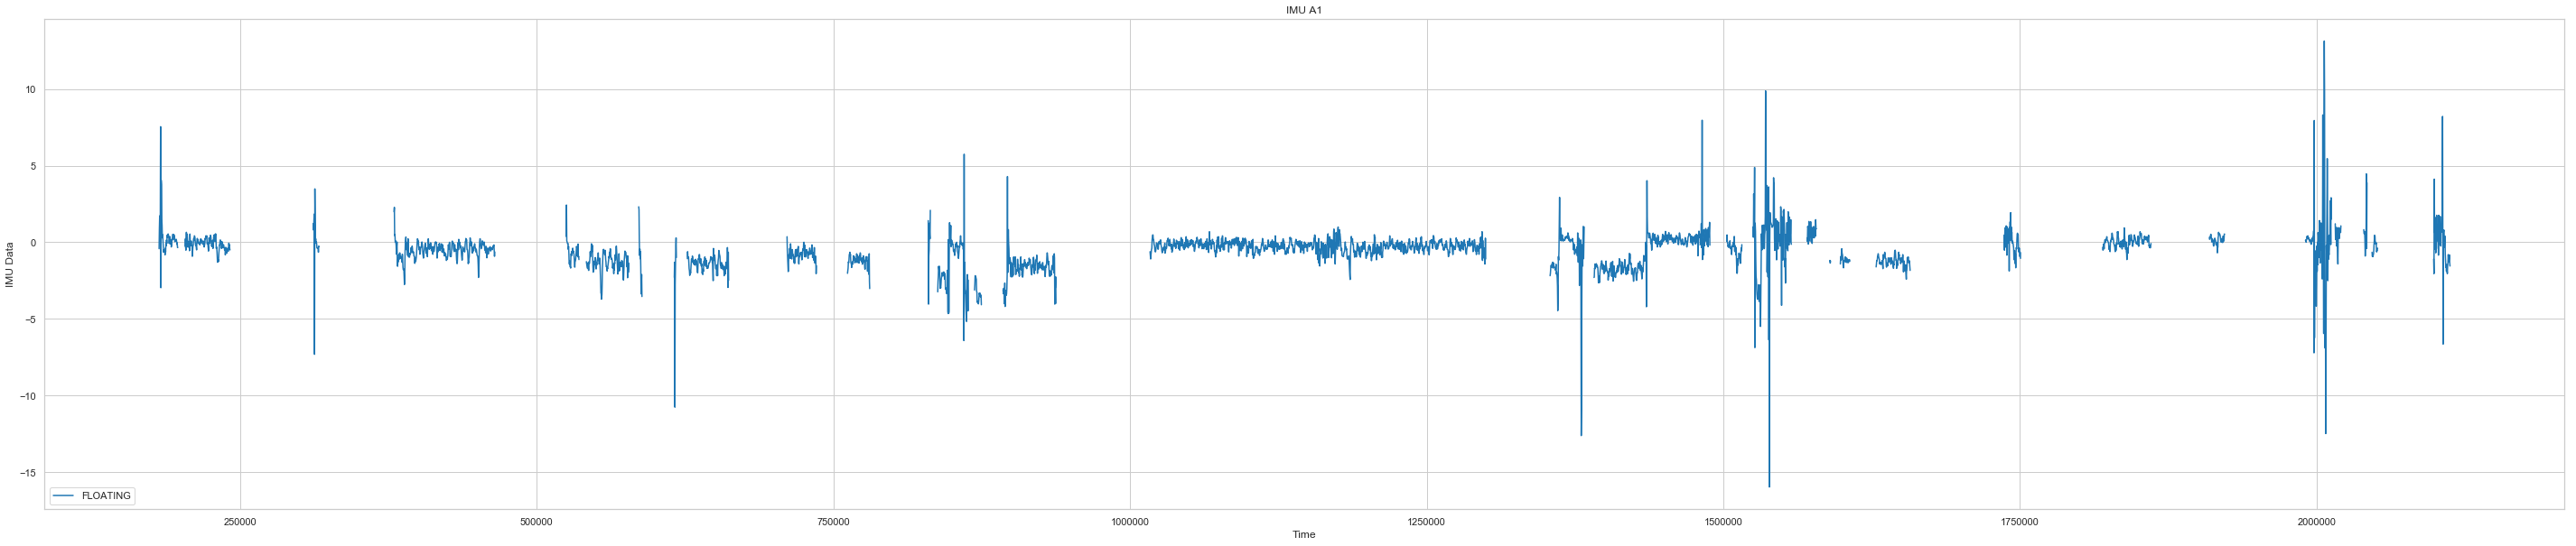

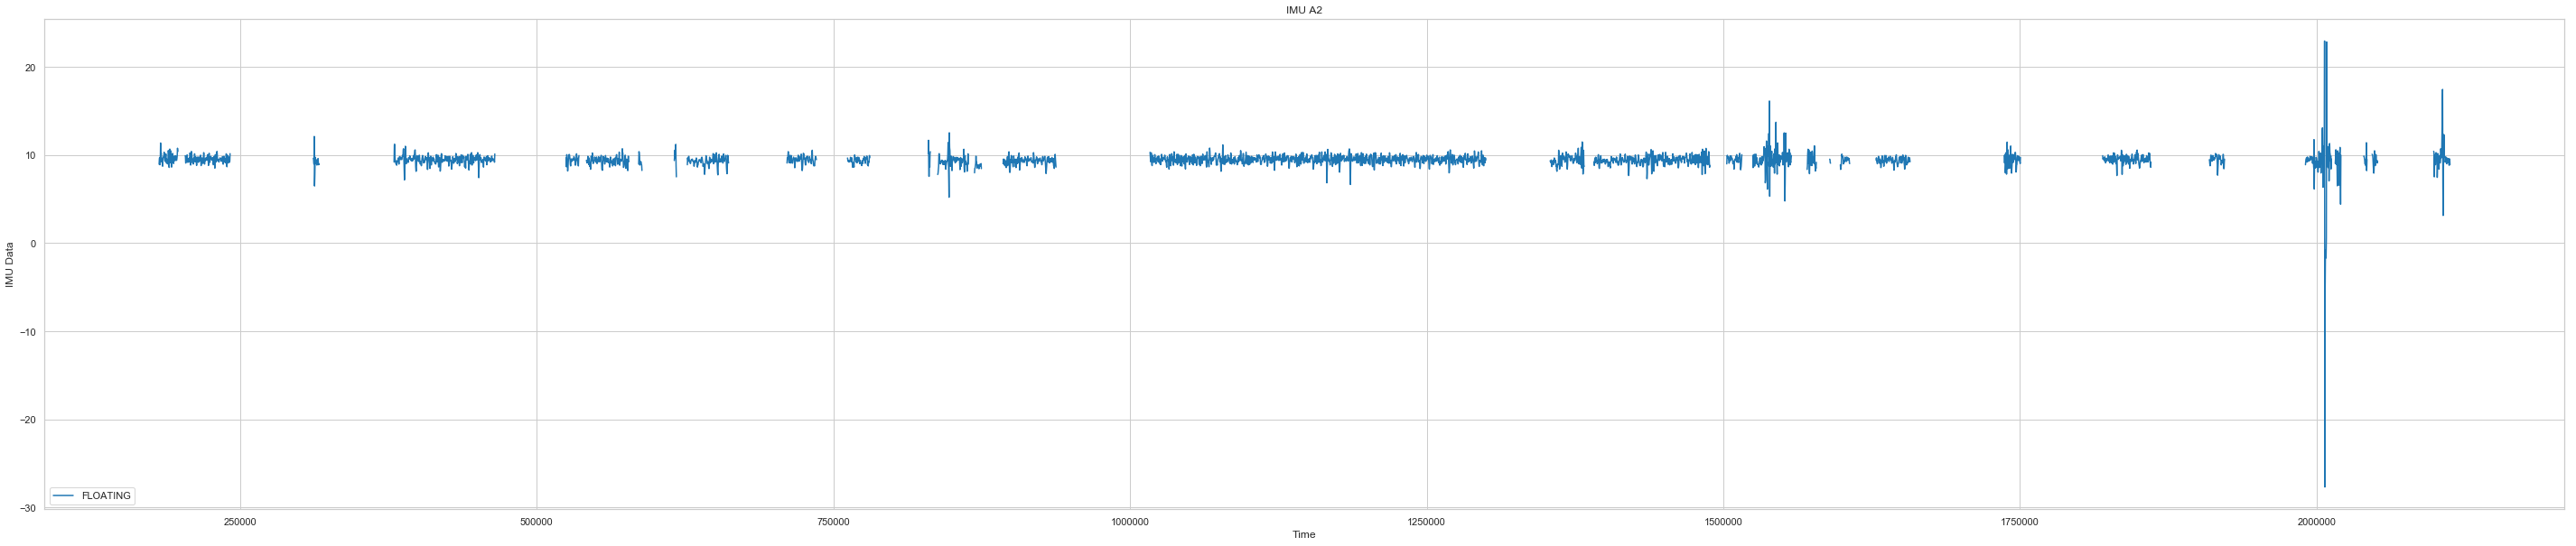

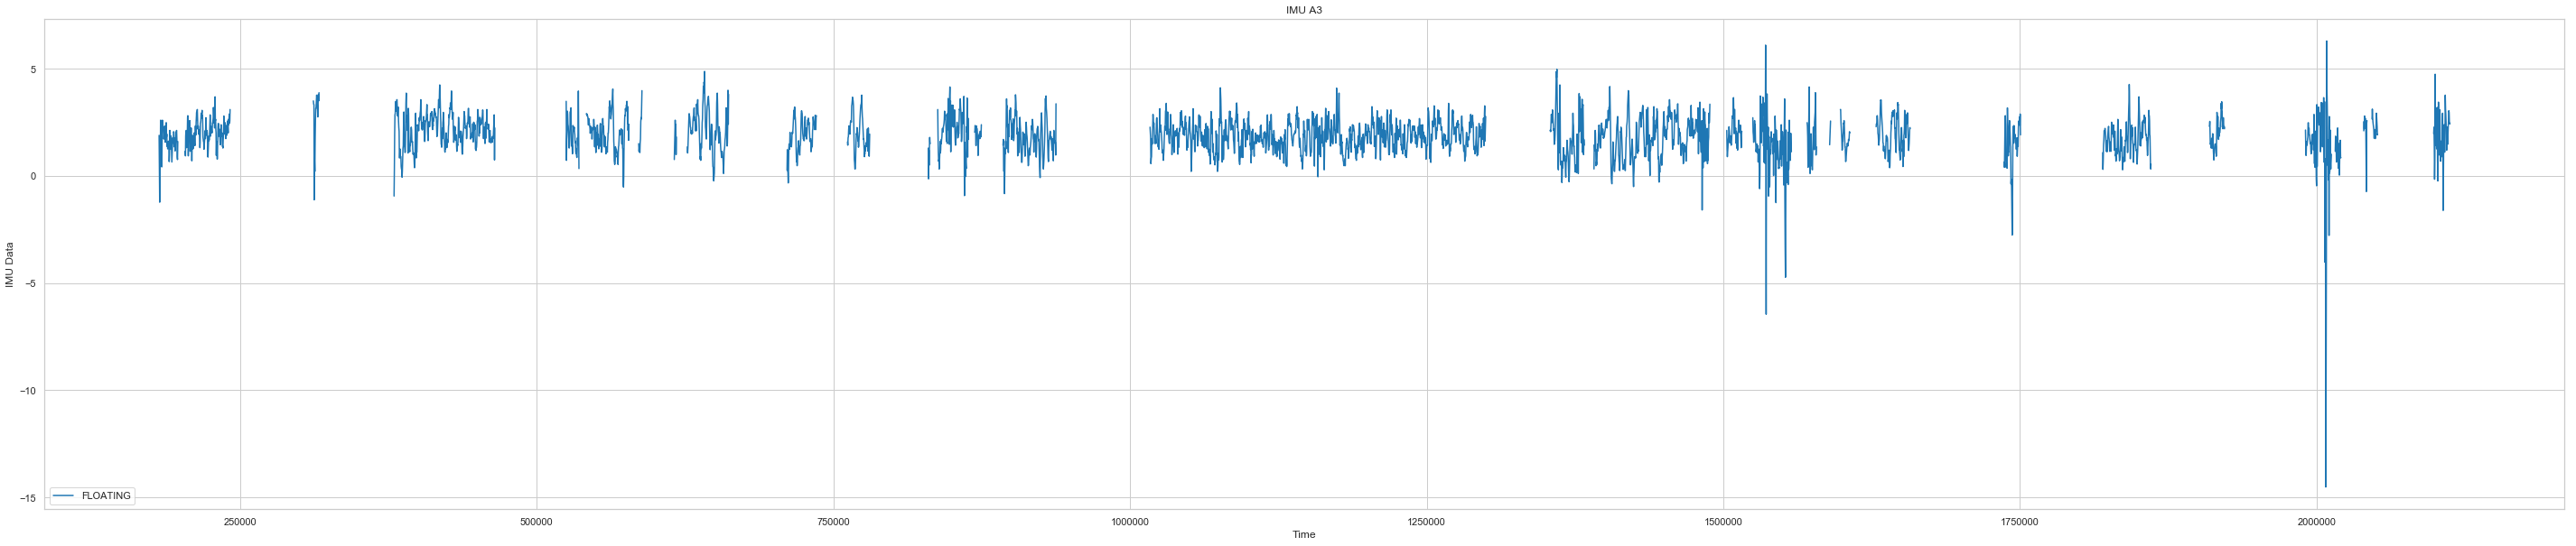

In [70]:

print("Creating Plots...")
createPlot(df_converted,'IMU A1')
createPlot(df_converted,'IMU A2')
createPlot(df_converted,'IMU A3')

In [73]:
#df_converted["IMU A2"]
df_converted["TimeDelta"]

ride_id  UTC                    
15692    2018-11-09 19:16:03.789          0.0
         2018-11-09 19:16:04.053        252.5
         2018-11-09 19:16:04.284        501.5
         2018-11-09 19:16:04.548        753.5
         2018-11-09 19:16:04.812       1003.5
         2018-11-09 19:16:05.043       1253.5
         2018-11-09 19:16:05.307       1504.5
         2018-11-09 19:16:05.571       1755.5
         2018-11-09 19:16:05.802       2006.5
         2018-11-09 19:16:06.066       2258.5
         2018-11-09 19:16:06.330       2507.5
         2018-11-09 19:16:06.561       2758.5
         2018-11-09 19:16:06.825       3009.5
         2018-11-09 19:16:07.056       3260.5
         2018-11-09 19:16:07.320       3501.5
         2018-11-09 19:16:07.551       3752.5
         2018-11-09 19:16:07.815       4003.5
         2018-11-09 19:16:08.079       4253.5
         2018-11-09 19:16:08.310       4503.5
         2018-11-09 19:16:08.574       4758.5
         2018-11-09 19:16:08.838       5009.5
 

### Now we can try analyzing a "floating" time-slice in the middle of this data: 

In [105]:
#Look at IMU A2 time-slice from 1,050,000 to 1,300,000:

keys = df_converted["TimeDelta"]
values = df_converted["IMU A2"]
imu_a2_time_dict = dict(zip(keys, values))

#Now need to slice the dictionary into 2 new lists: 
time_slice = []
imu_a2_slice = []
for time in imu_a2_time_dict:
    if time > 1050000 and time < 1300000:
        time_slice = float(time)
        #print(imu_a2_time_dict[time] - 9.80665)
        #Need to also subtract gravity from IMU A2 value:
        imu_a2_slice = float(imu_a2_time_dict[time] - 9.80665)

-0.8869439999999997
-0.7912390000000009
-0.3892780000000009
0.012682999999999112
-0.006458000000000297
-0.6189700000000009
-0.4084190000000003
-0.08302199999999971
-0.1213040000000003
-0.1595860000000009
-0.4275599999999997
-0.7912390000000009
-0.4658420000000003
0.2232339999999997
0.050964999999999705
-0.7146749999999997
-0.9252260000000003
-0.5998289999999997
0.2806569999999997
0.2615160000000003
-0.006458000000000297
-0.2935730000000003
-0.6955340000000003
-0.5424059999999997
-0.025598999999999705
-0.08302199999999971
-0.3701369999999997
-0.4084190000000003
-0.5041240000000009
-0.8486620000000009
-0.9826490000000003
-0.4275599999999997
-0.0638810000000003
0.031824000000000296
-0.1213040000000003
-0.1595860000000009
-0.1787270000000003
-0.10216300000000089
-0.025598999999999705
-0.2552909999999997
-0.7529570000000003
-0.8678030000000003
-0.3892780000000009
-0.025598999999999705
-0.4084190000000003
-1.020931000000001
-0.8295209999999997
-0.3127139999999997
-0.006458000000000297
0.0509

Plot not showing up for some reason - axis tick issue?


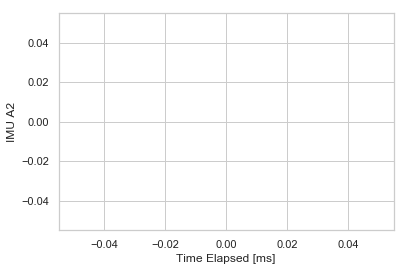

In [109]:
import matplotlib.pyplot as plt
import pylab
%matplotlib inline

print("Plot not showing up for some reason - axis tick issue?")

plt.plot(x=time_slice, y=imu_a2_slice, color="black", linewidth=2, markersize=12)
#plt.xticks=(np.arange(1050000, 1300000, step=50000))
plt.xlabel('Time Elapsed [ms]')
plt.ylabel('IMU A2')

plt.show();

### Detrend the data: 

In [ ]:
dacc_array = signal.detrend(imu_a2_slice)
f_s = 5.0 #sampling frequency

### Filter the data: 

    

In [ ]:
#Copy from: http://localhost:8890/notebooks/BuoyCallibratorData_DoubleIntegralAnalysis.ipynb

In [ ]:
#According to historic CDIP data: 
#http://cdip.ucsd.edu/offline/wavecdf/wnc_browse.php?ARCHIVE/201p1/201p1_historic+waveHs+201811
#Expecting significant wave height between 0.5 and 0.7m 
#Expecting wave period between 7s and 12s